In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-with-disaster-tweets/sample_submission.csv
/kaggle/input/nlp-with-disaster-tweets/train.csv
/kaggle/input/nlp-with-disaster-tweets/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #ve bieu do va hinh anh hoa du lieu
import tensorflow as tf

import string
import re

#tien xu ly van ban
import nltk #Natural Language Toolkit
nltk.download('stopwords') #tu dung
nltk.download('punkt') #phan doan tu
nltk.download('averaged_perceptron_tagger') #gan nhan tu loai
nltk.download('wordnet') #xu ly tu vung

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer #bien doi tu ve dang basic
from nltk.tokenize import word_tokenize #phan doan tu
from nltk.probability import FreqDist #tinh tan suat xuat hien cua tu

#mo hinh hoa
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #chuyen van ban thanh vector so
from sklearn.decomposition import LatentDirichletAllocation, NMF #giam chieu du lieu va phan tich chu de
from sklearn.metrics import f1_score, accuracy_score #danh gia hieu suat mo hinh

#thu vien cho word cloud va nhan dien thuc the(NER)
from wordcloud import WordCloud, STOPWORDS #de tao dam may tu (WordCloud)
from collections import Counter, defaultdict #dem va xu li du lieu
from PIL import Image #xu ly anh - Python Imaging Library

import spacy #xu li NLP va nhan dien thuc the (object)
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

#cac goi cot loi su dung chung trong notebook
import random
import warnings
import time
import datetime

#Tuy chinh, quan ly bo cuc va hien thi cua bieu do
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

2024-07-16 03:23:38.558188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 03:23:38.558307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 03:23:38.682717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 85.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011720 sha256=24358d3820019a3bc5037c0cb7a0fed4f4f8083b8fca7d31d3a33536fad21082
  Stored in directory: /root/.cache/pip/wheels/28/45/a9/c35b2107f053046bd5ac0b1adb5ea970938b02b134e49b9a06
Successfully built en_core_web_sm
  Attempting uninstall: en_core_web_sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstalled en-core-web-sm-3.7.1


/opt/conda/lib/python3.10/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.5,<3.8.0
  warnings.warn(warn_msg)


In [3]:
#Thu vien pytorch cho xu ly van ban
import torch #building and tranning model deep learning
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup #xu ly van ban,xay dung mo hinh phan loai,toi uu hoa cau hinh mo hinh BERT
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler #de tao va quan ly tap du lieu

**Thiet lap tuy chon chung**

In [4]:
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1.5) #tuy chinh kieu bieu do va font chu = 'seaborn'
pd.options.display.max_columns = 250 #thiet lao so cot, hang = pandas
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore') #bo qua cac canh bao

**Thiết lập seed để đảm bảo tính nhất quán của kết quả**

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

**Load Data**

In [6]:
df_train = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets/test.csv')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum()/1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test set Shape Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test set Shape Memory Usage = 0.10 MB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Khai thac data

In [9]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Start")
print(df_train["length"].describe())
print()

print("Test Length Start")
print(df_test["length"].describe())

Train Length Start
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Start
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


**Tien xu li data**

In [10]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split (X, y, test_size = VAL_SPLIT, random_state = 42)

X_test = df_test["text"]

**Xử lý từ viết tắt, hashtag**

In [12]:
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}
 
country_contractions = {
    'u.s': 'united states',
    'u.s.': 'united states',
    'u.s.a': 'united states',
    'u.k': 'united kingdom',
    'u.k.': 'united kingdom',
    'u.a.e': 'united arab emirates',
    'u.a.e.': 'united arab emirates',
    's.korea': 'south korea',
    'n.korea': 'north korea',
    'czech rep.': 'czech republic',
    'dominican rep.': 'dominican republic',
    'costa rica': 'republic of costa rica',
    'el salvador': 'republic of el salvador',
    'guinea-bissau': 'republic of guinea-bissau',
    'cote d\'ivoire': 'republic of cote d\'ivoire',
    'trinidad & tobago': 'republic of trinidad and tobago',
    'congo-brazzaville': 'republic of the congo',
    'congo-kinshasa': 'democratic republic of the congo',
    'sri lanka': 'democratic socialist republic of sri lanka',
    'central african rep.': 'central african republic',
    'san marino': 'republic of san marino',
    'são tomé & príncipe': 'democratic republic of são tomé and príncipe',
    'timor-leste': 'democratic republic of timor-leste'
}


In [13]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

**Chuẩn hóa văn bản**

In [14]:
def expand_contractions(text, contractions):
    words = text.split()
    expanded_words = []
    
    for word in words:
        if word in contractions:
            expanded_words.append(contractions[word])
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)


def convert_abbrev(word):
    word_lower = word.lower()
    if word_lower in abbreviations:
        return abbreviations[word_lower]
    return word


def convert_abbrev_in_text(text): #tách văn bản thành các từ
    tokens = word_tokenize(text)
    
    for i in range(len(tokens)):
        tokens[i] = convert_abbrev(tokens[i])

    text = ' '.join(tokens)
    
    return text


In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, r'', text)

def remove_punt(text): #loại bỏ dấu câu
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_space(text):
    return " ".join(text.split())

def clean_text(text): #để mở rộng các từ viết tắt trong văn bản
    text = expand_contractions(text, contractions)
    text = expand_contractions(text, country_contractions)  
    
    return text

In [16]:
#Làm sạch dữ liệu huấn luyện:
df_train['text_clean'] = df_train['text'].apply(lambda x: clean_text(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_URL(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_emoji(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_html(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_punt(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: convert_abbrev_in_text(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: remove_space(x))
df_train.head()

,id,keyword,location,text,target,length,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


In [17]:
#Làm sạch dữ liệu huấn luyện:
df_test['text_clean'] = df_test['text'].apply(lambda x: clean_text(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_URL(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_emoji(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_html(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_punt(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: convert_abbrev_in_text(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: remove_space(x))
df_test.head()

,id,keyword,location,text,length,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,34,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,Heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 in China and Taiwan


**Kiểm tra xem có GPU nào khả dụng**

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # Nếu có GPU thì ...
    # Số lượng GPU khả dụng và tên của GPU đang sử dụng
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [19]:
train = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets/train.csv')
test = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets/test.csv')

train['text'] = df_train['text_clean']
test['text'] = df_test['text_clean']

#Hiển thị một mẫu ngẫu nhiên từ tập dữ liệu:
display(train.sample(10)) 
#display(test.sample(10))


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause unimag...,1
2227,3185,deluge,NaN,The fing things I do for GISHWHES Just got soa...,0
5448,7769,police,UK,DT georgegalloway retweet Galloway4Mayor ÛÏTh...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great I...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,Calum5SOS you look like you got caught in a ra...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,brianroemmele UX fail of EMV people want to in...,1
6810,9756,tragedy,"Los Angeles, CA",Cant find my ariana grande shirt this is a fuc...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [20]:
#gắn nhãn cho tập dữ liệu huấn luyện
labels = train['target'].values
idx = len(labels)
combined = pd.concat([df_train, df_test]) #kết hợp hai DataFrame train và test lại với nhau theo chiều dọc
combined = combined.text.values

#Kết hợp hai tập dữ liệu giúp bạn xử lý dữ liệu thiếu và bất thường một cách nhất quán. Điều này đặc biệt hữu ích khi bạn cần điền giá trị thiếu hoặc xử lý các giá trị bất thường trong tập dữ liệu.

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True) #phien ban 'bert_base_uncased'  sử dụng các chữ cái không phân biệt hoa thường.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [22]:
max_len = 0

# Tính max_length của các câu trong combined
for text in combined:
    input_ids = tokenizer.encode(text, add_special_tokens = True) # Mã hóa thành một chuỗi các số nguyên biểu diễn cho các token trong câu
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [23]:
#Chia tập dữ liệu
train = combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [24]:
def tokenize_map(sentence,labs='None'):
        
    global labels
    
    input_ids = []
    attention_masks = []
    
    for text in sentence:
        encoded_dict = tokenizer.encode_plus( 
                            text,                          
                            add_special_tokens = True,      # add '[CLS]'、'[SEP]'
                            truncation='longest_first',     # Cắt bớt các token vượt quá max_length từ phía đầu tiên.
                            max_length = 84,                # Giới hạn độ dài tối đa của mỗi câu
                            pad_to_max_length = True,       # Thêm token [PAD] để đưa mọi câu về cùng độ dài max_length.
                            return_attention_mask = True,   # Trả về attention mask để chỉ ra các vị trí của các token thực sự so với token [PAD].
                            return_tensors = 'pt',          # Trả về tensors dưới dạng PyTorch tensors.
                       )

        #Làm đầy câu để có cùng độ dài max_length bằng cách thêm token [PAD].
        #return_attention_mask=True: Trả về attention mask để chỉ ra vị trí các token thực sự và token [PAD].
        #return_tensors='pt': Trả về tensors dưới dạng PyTorch tensors.
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs is not 'None': 
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks
        

In [25]:
input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [26]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))

val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} train samples')
print(f'{val_size} test samples')
      

6090 train samples
1523 test samples


In [27]:
batch_size = 16

train_dataloader = DataLoader(train_dataset,
                             sampler = RandomSampler(train_dataset),
                             batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                            sampler = RandomSampler(val_dataset),
                            batch_size = batch_size)

In [28]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)

prediction_sampler = SequentialSampler(prediction_data)

prediction_dataloader = DataLoader(prediction_data,
                                  sampler = prediction_sampler,
                                  batch_size = batch_size)

In [29]:
# Tạo mô hình BERT cho bài toán phân loại chuỗi
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', # Sử dụng mô hình BERT lớn với 24 lớp, 1024 đơn vị ẩn, 16 đầu attention và 340 triệu tham số.
                                                      num_labels = 2, # Số nhãn cho bài toán phân loại nhị phân (2 nhãn).
                                                      output_attentions = False, 
                                                      output_hidden_states = False,)
model.to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [30]:
params = list(model.named_parameters()) #lưu tất cả các tham số của mô hình, bao gồm tên và kích thước

print('The BERT model has {:} different named parameters.\n'. format(len(params)))

print('===== Embedding =====\n')
for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n===== First Transformer =====\n')
for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n===== Output Layer =====\n')
for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

===== Embedding =====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

===== First Transformer =====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (10

In [31]:
#optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

optimizer = AdamW(model.parameters(), lr = 6e-6, eps = 1.5e-8)

In [32]:
epochs = 4
total_steps = len(train_dataloader) * epochs

#scheduler để điều chỉnh learning rate
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps  = 0,
                                            num_training_steps = total_steps)


In [33]:
# Định nghĩa optimizer sử dụng SGD
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [34]:
# Định nghĩa optimizer sử dụng RMSprop
#optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [35]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

def format_time(elapsed):#định dạng thời gian elapsed từ giây thành dạng hh:mm
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded))

 **Huấn luyện mô hình**


In [36]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    t0 = time.time()
    
    total_train_loss = 0
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        if step%50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #Chuyển dữ liệu sang GPU và định dạng dữ liệu
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)
        
        #bỏ qua gradient 
        model.zero_grad() 
        
        # Forward pass để tính toán loss và logits
        outputs = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels)
        
        loss = outputs.loss  # This retrieves the loss from the model output
        logits = outputs.logits
        
        total_train_loss += loss.item()
        
        loss.backward() #Tính gradient của loss theo các tham số mô hình
        
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0) #cắt tỉ lệ gradient nếu nó vượt quá một ngưỡng nhất định
        
        optimizer.step() #cap nhat cac parameter
        
        scheduler.step()
        
    avg_train_loss = total_train_loss /len(train_dataloader)
    training_time = format_time(time.time() - t0)
        
    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time)) 



======== Epoch 1 / 4 ========
Training...
  Batch    50  of    381.    Elapsed: 0:00:24.
  Batch   100  of    381.    Elapsed: 0:00:47.
  Batch   150  of    381.    Elapsed: 0:01:10.
  Batch   200  of    381.    Elapsed: 0:01:33.
  Batch   250  of    381.    Elapsed: 0:01:56.
  Batch   300  of    381.    Elapsed: 0:02:20.
  Batch   350  of    381.    Elapsed: 0:02:43.

  Average training loss: 0.48
  Training epcoh took: 0:02:57

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    381.    Elapsed: 0:00:23.
  Batch   100  of    381.    Elapsed: 0:00:47.
  Batch   150  of    381.    Elapsed: 0:01:10.
  Batch   200  of    381.    Elapsed: 0:01:33.
  Batch   250  of    381.    Elapsed: 0:01:56.
  Batch   300  of    381.    Elapsed: 0:02:20.
  Batch   350  of    381.    Elapsed: 0:02:43.

  Average training loss: 0.35
  Training epcoh took: 0:02:57

======== Epoch 3 / 4 ========
Training...
  Batch    50  of    381.    Elapsed: 0:00:23.
  Batch   100  of    381.    Elapsed: 0:00

In [37]:
    print('')
    print('Running Test...')
        
    t0 = time.time()
    
    model.eval()
    
    #init
    total_test_accuracy = 0
    total_test_loss = 0
    total_test_f1 = 0
    nb_test_steps = 0

    for batch in validation_dataloader:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        #bao bọc phần forward pass để đảm bảo không tính toán gradient trong quá trình evaluation.
        with torch.no_grad():
            outputs = model(b_input_ids,
                                   token_type_ids = None,
                                   attention_mask = b_input_mask,
                                   labels = b_labels)
            loss = outputs.loss
            logits = outputs.logits
            
        total_test_loss += loss.item()
        
        #Chuyển logits và labels về CPU và tính toán accuracy và F1 score
        logits = logits.detach().cpu().numpy() #Chuyển logits về numpy array trên cpu
        labels_ids = b_labels.to('cpu').numpy()
        
        total_test_accuracy += flat_accuracy(logits, labels_ids)
        total_test_f1 += flat_f1(logits, labels_ids)
        
    avg_test_accuracy = total_test_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_test_accuracy))
    
    avg_test_f1 = total_test_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_test_f1))

    avg_test_loss = total_test_loss / len(validation_dataloader)
    
    test_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_test_loss))
    print('  Validation took: {:}'.format(test_time))
        
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss,
            'Test Accur.': avg_test_accuracy,
            'Test_F1' : avg_test_f1,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time() - total_t0)))


Running Test...
  Accuracy: 0.84
  F1: 0.79
  Validation Loss: 0.47
  Validation took: 0:00:13

Training complete!
Total training took 0:12:02 (h:mm:ss)


In [38]:
# Cài đặt độ chính xác cho các số thực trong DataFrame của pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Tạo DataFrame để lưu các thống kê huấn luyện
df_stats = pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')  # Đặt cột 'epoch' làm chỉ số
display(df_stats)  # Hiển thị DataFrame



,Training Loss,Test Loss,Test Accur.,Test_F1,Training Time,Test Time
epoch,,,,,,
4,0.25,0.47,0.84,0.79,0:02:57,0:00:13


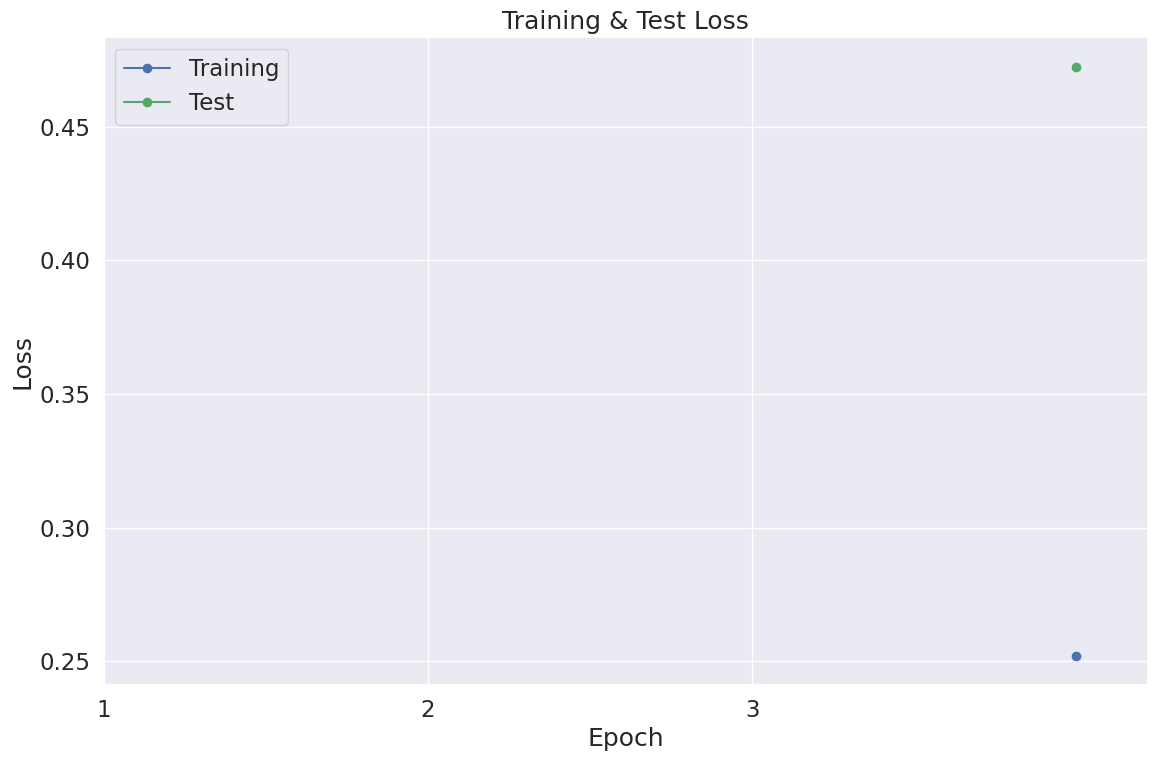

In [39]:
# Vẽ biểu đồ sự thay đổi của training loss và validation loss qua các epoch
fig, axes = plt.subplots(figsize=(12, 8))

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Test Loss'], 'g-o', label='Test') 

# Thêm nhãn và chú thích vào biểu đồ
plt.title('Training & Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3])  # Tinh chỉnh các tick trên trục x nếu cần

plt.show()  # Hiển thị biểu đồ

In [40]:
print('Dự đoán nhãn cho {:,} câu kiểm tra...'.format(len(test_input_ids)))
model.eval()  # Đặt mô hình vào chế độ đánh giá
predictions = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device)for t in batch) #Chuyen batch sang GPU
    
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids,
                       token_type_ids = None,
                        attention_mask = b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions.append(logits)
    
print(' DONE. ')
    

Dự đoán nhãn cho 3,263 câu kiểm tra...
 DONE. 


In [41]:
# Gộp các dự đoán thành một danh sách phẳng và lấy nhãn dự đoán
flat_predictions = [item for sublit in predictions for item in sublit]
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten() # Chọn lớp có xác suất cao nhất là dự đoán


In [42]:
# Tải file sample_submission.csv làm mẫu để nộp
submission = pd.read_csv('/kaggle/input/nlp-with-disaster-tweets/sample_submission.csv')

# Cập nhật cột 'target' trong DataFrame submission với flat_predictions
submission['target'] = flat_predictions

# Hiển thị 10 hàng đầu tiên của DataFrame submission
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [43]:
# Lưu DataFrame submission vào file CSV mà không bao gồm chỉ số và có header
submission.to_csv('submission.csv', index = False, header = True)